<a href="https://colab.research.google.com/github/jeetch/Kaggle-Ion-Switching/blob/master/Ion_Switching_Baseline_LGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ion Switching - University of Liverpool

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
#import catboost as cat

# Preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

#from tqdm import tqdm_notebook

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
test = pd.read_csv('/content/drive/My Drive/DS Projects/Ion-Switching/test_clean.csv')
train = pd.read_csv('/content/drive/My Drive/DS Projects/Ion-Switching/train_clean.csv')

In [0]:
train.head()

In [0]:
test.head()

In [0]:
train['open_channels'].value_counts().plot(kind='bar')

In [0]:
train['batch'] = 0
for i in range(0, 10):
    train.iloc[i * 500000: 500000 * (i + 1), 3] = i

In [0]:
train.head()

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 8));

In [0]:
plt.figure(figsize=(26, 12))
for i, b in enumerate(train['batch'].unique()):
    plt.subplot(2, 5, i + 1)
    plt.plot(train.loc[train['batch'] == b, ['signal']], color='blue')
    plt.title(f'Batch: {b}')
    ax1.set_ylabel(b, color='b')
    # plt.legend([col])
    ax2 = ax1.twinx()
    plt.plot(train.loc[train['batch'] == b, ['open_channels']], color='g')
    ax2.set_ylabel('Open channels', color='g')
    plt.legend([b, 'open_channels'], loc=(0.875, 0.9))
    plt.grid(False)

### Feature Engineering

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df

In [0]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 25_000
    df['batch_index'] = df.index  - (df.batch * 25_000)
    df['batch_slices'] = df['batch_index']  // 2500
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        d['range'+c] = d['max'+c] - d['min'+c]
        d['maxtomin'+c] = d['max'+c] / d['min'+c]
        d['abs_avg'+c] = (d['abs_min'+c] + d['abs_max'+c]) / 2
        for v in d:
            df[v] = df[c].map(d[v].to_dict())

    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
    
    df = reduce_mem_usage(df)
    df.fillna(0, inplace=True) 
    return df

In [0]:
train = features(train)
test = features(test)


In [0]:
train.to_pickle('/content/drive/My Drive/DS Projects/Ion-Switching/train_ion_lgb_feat.pkl')
test.to_pickle('/content/drive/My Drive/DS Projects/Ion-Switching/test_ion_lgb_feat.pkl')

In [0]:
train=pd.read_pickle('/content/drive/My Drive/DS Projects/Ion-Switching/train_ion_lgb_feat.pkl')
test=pd.read_pickle('/content/drive/My Drive/DS Projects/Ion-Switching/test_ion_lgb_feat.pkl')

In [0]:
#test.head()

In [12]:
print(train.shape,test.shape)

(5000000, 54) (2000000, 53)


In [0]:
train.drop(columns='batch_slices2',inplace = True)

In [0]:
test.drop(columns='batch_slices2',inplace = True)

### Modelling

In [0]:
target = 'open_channels'
feat = train.columns
feat = feat.drop(target)

In [15]:
target

'open_channels'

In [0]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='macro'), True


In [0]:
def lgb_model(train, features, target, ts=False, plot=True):
    evals_result = {}
    trainX, validX, trainY, validY = train_test_split(train[features], train[target], shuffle=False, test_size=0.2, random_state=13)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 1000
    lgb_params = {
        "boosting": 'gbdt',
        "learning_rate": 0.05,
        "num_leaves" : 200,
        'metric': 'logloss',
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": 'regression',
        'average' : 'micro'
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=100,
        verbose_eval=50,
        evals_result=evals_result,
        
        feval=lgb_f1_score # New metric to be optimised
    )
    if plot:
        lgb.plot_importance(lgb_model, figsize=(24, 24))
        lgb.plot_metric(evals_result, metric='f1')

    return lgb_model, lgb_model.best_score

LGB Model


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's f1: 0.763728	valid_1's f1: 0.75637
[100]	training's f1: 0.938039	valid_1's f1: 0.928928
[150]	training's f1: 0.938786	valid_1's f1: 0.929256
[200]	training's f1: 0.939715	valid_1's f1: 0.929186
[250]	training's f1: 0.94045	valid_1's f1: 0.929164
Early stopping, best iteration is:
[170]	training's f1: 0.939112	valid_1's f1: 0.929329


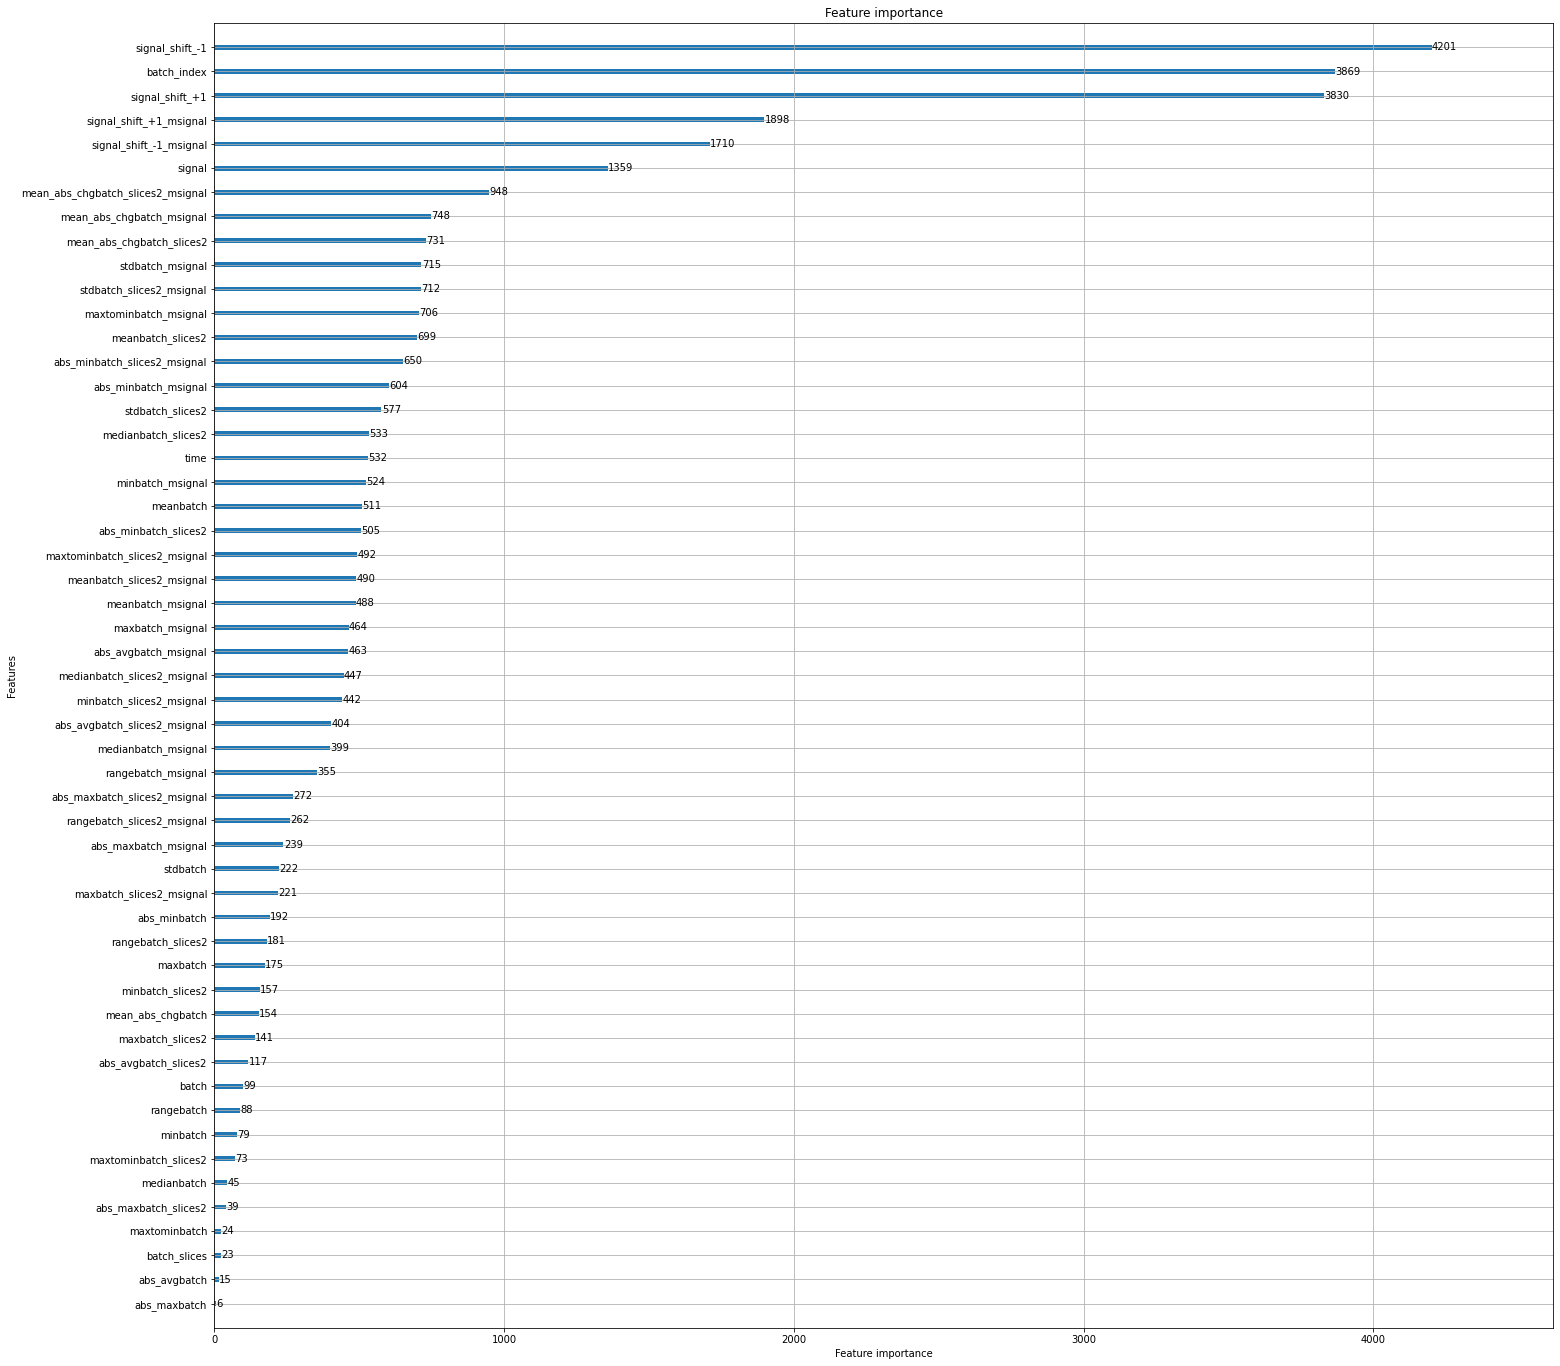

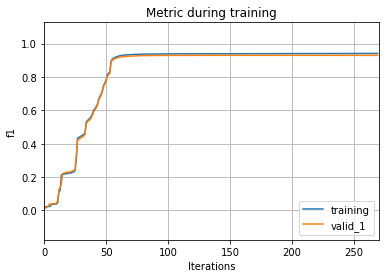

In [18]:
lgbM, score = lgb_model(train, feat, target, True, True)

In [19]:
y_preds = lgbM.predict(test[feat])
y_preds

array([0.00225213, 0.00047823, 0.00047823, ..., 0.00047823, 0.00047823,
       0.01904618])

In [20]:
y_preds.shape


(2000000,)

In [0]:
def convert_to_one_hot(pred):
    '''
    Convert the prediction into probabilities
    Example: 1.6 --> [0, 0.4, 0.6, 0, 0, ...]
    1.6 is closer to 2 than to 1
    All rows will sum 1
    '''

    # clip results lower or higher than limits
    pred = np.clip(pred, 0, 10)

    # convert to "one-hot"
    pred = 1 - np.abs(pred.reshape((-1,1)) - np.arange(11))

    # clip results lower than 0
    pred = np.clip(pred, 0, 1)
    
    return pred
    

In [0]:
y_pred_o = convert_to_one_hot(y_preds)

In [23]:
y_pred_o.shape

(2000000, 11)

In [0]:
y_pred_o = np.argmax(y_pred_o, axis=-1)

In [25]:
len(y_pred_o)

2000000

In [0]:
test_org = pd.read_csv('/content/drive/My Drive/DS Projects/Ion-Switching/test_clean.csv')

In [0]:
submission = pd.DataFrame()
submission['time'] = test_org['time']
submission['open_channels'] = y_pred_o
submission.to_csv('submission_2.csv', index=False, float_format='%.4f')

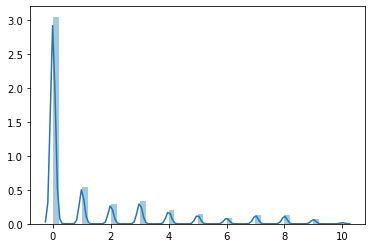

In [0]:
#len(y_preds_rd)
sns.distplot(y_pred_o)